In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import namedtuple

In [2]:
LATENT_SPACE_SIZE = 128
IMAGE_SIZE = 64
device = 'cuda:8'
ngpu = 4

In [17]:
def normalize_gaussian(x):
    return (x - x.mean()) / (x.std() + 0.00000001)

def normalize_minmax(x):
    x = (x - x.min())
    return x / x.max()

def random_noise(size):
    return torch.rand(size)

In [4]:
def display_image(image, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    image = image.cpu()
    image = torch.clip(image * torch.FloatTensor(std) + torch.FloatTensor(std), 0, 1)
    plt.imshow(image)
    plt.show()

In [5]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.RandomRotation((-10, 10)),
    torchvision.transforms.CenterCrop(196),
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(196),
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = torchvision.datasets.LFWPairs(root='.data/', split='train', download=True, transform=train_transform)
test_dataset = torchvision.datasets.LFWPairs(root='.data/', split='test', download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print('Shape: %s' % (train_dataset[0][0].shape,))
print('Mean: %.4f' % train_dataset[0][0].mean())
print('Std: %.4f' % train_dataset[0][0].std())
print('Min: %.4f' % train_dataset[0][0].min())
print('Max: %.4f' % train_dataset[0][0].max())

Shape: torch.Size([3, 64, 64])
Mean: 0.2300
Std: 0.5319
Min: -0.9608
Max: 0.9765


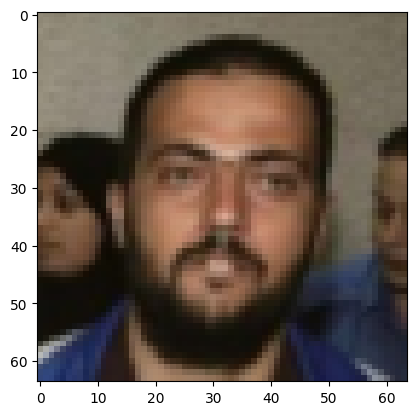

In [7]:
display_image(train_dataset[3][0].permute(1, 2, 0))

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

class EncoderBlock(torch.nn.Module):

    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3, bn=False):
        super(EncoderBlock, self).__init__()

        if bn:
            self.head = torch.nn.Sequential(
                torch.nn.BatchNorm2d(num_features=in_channels),
                torch.nn.ConvTranspose2d(in_channels, hidden_channels[0], 2, 2, 0),
                torch.nn.Sigmoid(),
                torch.nn.Dropout2d(dropout),
            )
        else:
            self.head = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(in_channels, hidden_channels[0], 2, 2, 0),
                torch.nn.Sigmoid(),
                torch.nn.Dropout2d(dropout),
            )

        hidden_layers = []
        last_channel = hidden_channels[0]
        for hidden_channel in hidden_channels:
            hidden_layers.append(torch.nn.Conv2d(last_channel, hidden_channel, kernel_size=(3, 3), stride=1, padding=1))
            hidden_layers.append(torch.nn.ReLU())
            last_channel = hidden_channel

        self.hidden = torch.nn.Sequential(*hidden_layers)

        self.tail = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            torch.nn.Conv2d(last_channel, out_channels, kernel_size=(3, 3), stride=1, padding=1),
            torch.nn.ReLU(),
        )
    
    def forward(self, input):
        head = self.head(input)
        hidden = self.hidden(head)
        tail = self.tail(hidden)
        return tail


class DecoderBlock(torch.nn.Module):

    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3, bn=False):
        super(DecoderBlock, self).__init__()
        if bn:
            self.head = torch.nn.Sequential(
                torch.nn.BatchNorm2d(num_features=in_channels),
                torch.nn.ConvTranspose2d(in_channels, hidden_channels[0], 2, 2, 0),
                torch.nn.Sigmoid(),
                torch.nn.Dropout2d(dropout),
            )
        else:
            self.head = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(in_channels, hidden_channels[0], 2, 2, 0),
                torch.nn.Sigmoid(),
                torch.nn.Dropout2d(dropout),
            )

        hidden_layers = []
        last_channel = hidden_channels[0]
        for hidden_channel in hidden_channels:
            hidden_layers.append(torch.nn.Conv2d(last_channel, hidden_channel, kernel_size=(3, 3), stride=1, padding=1))
            hidden_layers.append(torch.nn.ReLU())
            last_channel = hidden_channel

        self.hidden = torch.nn.Sequential(*hidden_layers)

        self.tail = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            torch.nn.Conv2d(last_channel, out_channels, kernel_size=(3, 3), stride=1, padding=1),
            torch.nn.ReLU(),
        )
    
    def forward(self, input):
        head = self.head(input)
        hidden = self.hidden(head)
        tail = self.tail(hidden)
        return tail


class DownsampleBlock(torch.nn.Module):

    def __init__(self, in_channels, channels, dropout=0.3):
        super(DownsampleBlock, self).__init__()
        layers = []
        last_channel = in_channels
        for channel in channels:
            layers.append(torch.nn.Conv2d(last_channel, channel, kernel_size=(2, 2), stride=2, padding=0))
            layers.append(torch.nn.ReLU())
            last_channel = channel

        self.model = torch.nn.Sequential(*layers)
    
    def forward(self, input):
        output = self.model(input)
        return output


class UpsampleBlock(torch.nn.Module):

    def __init__(self, in_channels, channels, dropout=0.3):
        super(UpsampleBlock, self).__init__()
        layers = []
        last_channel = in_channels
        for channel in channels:
            layers.append(torch.nn.ConvTranspose2d(last_channel, channel, 2, 2, 0, bias=False))
            layers.append(torch.nn.ReLU())
            last_channel = channel

        self.model = torch.nn.Sequential(*layers)
    
    def forward(self, input):
        output = self.model(input)
        return output

In [9]:
class Encoder(torch.nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(3, 8, kernel_size=(1, 1), stride=1, padding=0),
            torch.nn.ReLU(),
            
            EncoderBlock(8, [12, 12, 12], 8),

            DownsampleBlock(8, [16, 32]),

            EncoderBlock(32, [48, 48, 48], 32), 

            DownsampleBlock(32, [64, 128]),

            EncoderBlock(128, [196, 196, 196], 128), 
            
            DownsampleBlock(128, [256, 512]),

            EncoderBlock(512, [768, 768, 768], 512), 

            torch.nn.AvgPool2d(3),

            torch.nn.Conv2d(512, LATENT_SPACE_SIZE, kernel_size=(1, 1), stride=1, padding=0),
            torch.nn.Tanh(),
        )

    def forward(self, input):
        output = self.model(input)
        output = output.squeeze(3).squeeze(2)
        return output

encoder = Encoder().to(device)
print(encoder(torch.rand((2, 3, IMAGE_SIZE, IMAGE_SIZE)).to(device)).shape)

RuntimeError: Given input size: (512x1x1). Calculated output size: (512x0x0). Output size is too small

In [43]:
class DecoderOld(torch.nn.Module):

    def __init__(self):
        super(DecoderOld, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(LATENT_SPACE_SIZE, 512, kernel_size=(1, 1), stride=1, padding=0),
            torch.nn.ReLU(),

            torch.nn.Upsample(size=(3, 3), mode='nearest'),

            DecoderBlock(512, [768, 768, 768], 512), 

            UpsampleBlock(512, [256, 128]),
            torch.nn.Upsample(size=(14, 14), mode='nearest'),

            DecoderBlock(128, [196, 196, 196], 128), 

            UpsampleBlock(128, [64, 32]),

            DecoderBlock(32, [48, 48, 48], 32), 
            
            UpsampleBlock(32, [16, 8]),

            DecoderBlock(8, [12, 12, 12], 8), 

            torch.nn.Conv2d(8, 3, kernel_size=(1, 1), stride=1, padding=0),   

            torch.nn.Tanh(),
        )

    def forward(self, input):
        input = input.unsqueeze(-1).unsqueeze(-1)
        output = self.model(input)
        return (output + 1) / 2

# IMAGE_SIZE -> [112 -> 56] -> [28 -> 14] -> [7 -> 3]
decoder = DecoderOld().to(device)
print(decoder(random_noise((2, LATENT_SPACE_SIZE)).to(device)).shape)

torch.Size([2, 3, 224, 224])


In [10]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = torch.nn.Sequential(
            # input is Z, going into a convolution
            torch.nn.ConvTranspose2d(128, 64, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),
            # state size. (64) x 4 x 4
            torch.nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(True),
            # state size. (32) x 8 x 8
            torch.nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(True),
            # state size. (16) x 16 x 16
            torch.nn.ConvTranspose2d(16, 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(True),
            # state size. (8) x 32 x 32
            torch.nn.ConvTranspose2d(8, 3, 4, 2, 1, bias=False),
            torch.nn.Tanh()
            # state size. (3) x 64 x 64
        )

    def forward(self, input):
        input = input.unsqueeze(-1).unsqueeze(-1)
        output = self.model(input)
        return output


decoder = Decoder().to(device)
print(decoder(random_noise((2, LATENT_SPACE_SIZE)).to(device)).shape)

torch.Size([2, 3, 64, 64])


In [14]:
class DiscriminatorOld(torch.nn.Module):

    def __init__(self):
        super(DiscriminatorOld, self).__init__()
        self.model = torchvision.models.GoogLeNet(2)

    def forward(self, input):
        output = self.model(input)
        if self.model.training:
            out = output.logits
            aux1 = output.aux_logits1
            aux2 = output.aux_logits2
            return out, aux1, aux2
        else:
            return output

discriminator = DiscriminatorOld().to(device)
print(discriminator(torch.rand((2, 3, IMAGE_SIZE, IMAGE_SIZE)).to(device))[0])

/home/azamat_bakytzhan/.conda/envs/dl-final-project/lib/python3.9/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


tensor([[-0.1480, -0.2329],
        [ 0.1031,  0.1581]], device='cuda:8', grad_fn=<AddmmBackward0>)


In [11]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = torch.nn.Sequential(
            # input is (nc) x 64 x 64
            torch.nn.Conv2d(3, 8, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            torch.nn.Conv2d(8, 16, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            torch.nn.Conv2d(16, 32, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            torch.nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            torch.nn.Conv2d(64, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input).squeeze(3).squeeze(2)

discriminator = Discriminator().to(device)
print(discriminator(torch.rand((2, 3, IMAGE_SIZE, IMAGE_SIZE)).to(device))[0])

tensor([0.5963], device='cuda:8', grad_fn=<SelectBackward0>)


In [12]:
Model = namedtuple('Model', ['encoder', 'decoder', 'discriminator'])

model = Model(
    encoder=Encoder().to(device),
    decoder=Decoder().to(device),
    discriminator=Discriminator().to(device),
)

# model.encoder.load_state_dict(torch.load('.models/encoder-3.pt'))
# model.decoder.load_state_dict(torch.load('.models/decoder-small.pt'))
# model.discriminator.load_state_dict(torch.load('.models/discriminator-small.pt'))


if (ngpu > 1):
    model._replace(decoder=torch.nn.DataParallel(model.decoder, list(range(ngpu))))

if (ngpu > 1):
    model._replace(discriminator=torch.nn.DataParallel(model.discriminator, list(range(ngpu))))


model.decoder.apply(weights_init)
model.discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(64, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [13]:
def pair_distance(a, b, p):
    pdist = torch.nn.PairwiseDistance(p=p)
    return pdist(a, b)

pair_distance(torch.rand((2, LATENT_SPACE_SIZE)).to(device), torch.rand((2, LATENT_SPACE_SIZE)).to(device), LATENT_SPACE_SIZE)

tensor([0.9443, 0.8568], device='cuda:8')

In [14]:
def mean_squared_loss(a, b):
    return torch.pow((a - b), 2).mean()

In [88]:
def reciprocity_loss(batch_size, model):
    points = random_noise((batch_size, LATENT_SPACE_SIZE)).to(device)
    fake_faces = model.decoder(points)
    fake_points = model.encoder(fake_faces)
    return mean_squared_loss(points, fake_points)

model.encoder.train()
model.decoder.train()
model.discriminator.eval()

reciprocity_loss(8, model)

RuntimeError: Given input size: (512x1x1). Calculated output size: (512x0x0). Output size is too small

In [49]:
def reconstruction_loss(faces, model):
    reconstructed_faces = model.decoder(model.encoder(faces))
    size = faces.shape[1] * faces.shape[2] * faces.shape[3]
    faces = faces.view(faces.shape[0], size)
    reconstructed_faces = reconstructed_faces.view(reconstructed_faces.shape[0], size)
    return mean_squared_loss(faces, reconstructed_faces)

model.encoder.train()
model.decoder.train()
model.discriminator.eval()

reconstruction_loss(torch.rand((4, 3, IMAGE_SIZE, IMAGE_SIZE)).to(device), model)

tensor(0.0995, device='cuda:8', grad_fn=<MeanBackward0>)

In [50]:
def contrastive_loss(positive_pairs, negative_pairs, margin, model):
    if positive_pairs.shape[0] > 0:
        positive_points_a = model.encoder(positive_pairs[:, 0, :, :, :])
        positive_points_b = model.encoder(positive_pairs[:, 1, :, :, :])
        positive_loss = pair_distance(positive_points_a, positive_points_b, LATENT_SPACE_SIZE).mean()
    else:
        positive_loss = torch.autograd.Variable(torch.FloatTensor([0]).to(device))
    
    if negative_pairs.shape[0] > 0:
        negative_points_a = model.encoder(negative_pairs[:, 0, :, :, :])
        negative_points_b = model.encoder(negative_pairs[:, 1, :, :, :])
        negative_distances = pair_distance(negative_points_a, negative_points_b, LATENT_SPACE_SIZE)
        negative_loss = torch.max(torch.autograd.Variable(torch.FloatTensor([0]).to(device)), margin - negative_distances).mean()
    else:
        negative_loss = torch.autograd.Variable(torch.FloatTensor([0]).to(device))

    return (positive_loss + negative_loss) / 2

model.encoder.train()
model.decoder.train()
model.discriminator.eval()

contrastive_loss(torch.rand((3, 2, 3, IMAGE_SIZE, IMAGE_SIZE)).to(device), torch.rand((3, 2, 3, IMAGE_SIZE, IMAGE_SIZE)).to(device), 10, model)

tensor(5., device='cuda:8', grad_fn=<DivBackward0>)

In [23]:
def discriminator_loss(true_faces, fake_faces_size, model):
    criterion = torch.nn.BCELoss()

    points = random_noise((fake_faces_size, LATENT_SPACE_SIZE)).to(device)
    fake_faces = model.decoder(points)

    true_labels = torch.full((true_faces.size(0),), 1, dtype=torch.float, device=device)
    fake_labels = torch.full((fake_faces.size(0),), 0, dtype=torch.float, device=device)
    
    faces = torch.concat([true_faces, fake_faces], dim=0)
    labels = torch.concat([true_labels, fake_labels], dim=0)
    
    out = model.discriminator(faces.detach()).squeeze(1)

    loss = criterion(out, labels)

    return loss

model.encoder.eval()
model.decoder.eval()
model.discriminator.train()

discriminator_loss(torch.rand((2, 3, IMAGE_SIZE, IMAGE_SIZE)).to(device), 3, model)

tensor(0.6210, device='cuda:8', grad_fn=<BinaryCrossEntropyBackward0>)

In [24]:
def generative_loss(batch_size, model):
    criterion = torch.nn.BCELoss()

    points = random_noise((batch_size, LATENT_SPACE_SIZE)).to(device)

    fake_faces = model.decoder(points)
    fake_labels = torch.full((fake_faces.size(0),), 1, dtype=torch.float, device=device)
    
    out = model.discriminator(fake_faces).squeeze(1)

    loss = criterion(out, fake_labels)

    return loss

model.encoder.train()
model.decoder.train()
model.discriminator.eval()

generative_loss(4, model)

tensor(0.6815, device='cuda:8', grad_fn=<BinaryCrossEntropyBackward0>)

In [61]:
# contrastive_loss(torch.rand((3, 2, 3, 256, 256)).to(device), torch.rand((3, 2, 3, 256, 256)).to(device), 10, model)

def pass_one(batch, optimizer, model, show=False):
    batch_size = batch[0].shape[0]

    faces_a, faces_b, matches = batch
    faces_a = faces_a.to(device)
    faces_b = faces_b.to(device)
    matches = matches.to(device)

    positive_pairs = torch.concat([
        faces_a.unsqueeze(1)[matches == 1, :, :, :, :],
        faces_b.unsqueeze(1)[matches == 1, :, :, :, :],
    ], dim=1)

    negative_pairs = torch.concat([
        faces_a.unsqueeze(1)[matches == 0, :, :, :, :],
        faces_b.unsqueeze(1)[matches == 0, :, :, :, :],
    ], dim=1)

    model.encoder.train()
    model.decoder.train()
    model.discriminator.eval()

    # optimizer.encoder.zero_grad()
    optimizer.decoder.zero_grad()

    # r_loss = reciprocity_loss(batch_size, model)
    # r_loss.backward()

    g_loss = generative_loss(batch_size, model)
    g_loss.backward()

    # rec_loss = reconstruction_loss(torch.concat([faces_a, faces_b], dim=0), model)
    # rec_loss.backward()

    # optimizer.encoder.step()
    optimizer.decoder.step()

    if show:
        print("Reconstruction loss: %.4f, Reciprocity loss: %.4f, Generative loss: %.4f," % (0, 0, g_loss), end=' ')



def pass_two(batch, optimizer, model, show=False):
    batch_size = batch[0].shape[0]
    
    faces_a, faces_b, _ = batch
    faces_a = faces_a.to(device)
    faces_b = faces_b.to(device)

    faces = torch.concat([faces_a, faces_a], dim=0)

    model.encoder.eval()
    model.decoder.eval()
    model.discriminator.train()

    optimizer.discriminator.zero_grad()

    d_loss = discriminator_loss(faces, batch_size, model)
    d_loss.backward()

    optimizer.discriminator.step()

    if show:
        print("Discriminator loss: %.4f," % (d_loss,))


def pass_epoch(batch, optimizer, model, show=False):
    pass_one(batch, optimizer, model, show)
    pass_two(batch, optimizer, model, show)

In [28]:
def generator_and_discriminator(batch, optimizer, model):
    batch_size = batch[0].shape[0]

    faces_a, faces_b, _ = batch
    faces_a = faces_a.to(device)
    faces_b = faces_b.to(device)

    faces = torch.concat([faces_a, faces_b], dim=0)

    model.decoder.eval()
    model.discriminator.train()

    optimizer.discriminator_exp.zero_grad()

    d_loss = discriminator_loss(faces, 2 * batch_size, model)
    d_loss.backward()

    optimizer.discriminator_exp.step()

    model.decoder.train()
    model.discriminator.eval()

    optimizer.decoder_exp.zero_grad()

    g_loss = generative_loss(2 * batch_size, model)
    g_loss.backward()

    optimizer.decoder_exp.step()

    return "Discriminator loss: %.4f, Generative loss: %.4f" % (d_loss, g_loss,)

In [28]:
def encoder_decoder(batch, optimizer, model):
    batch_size = batch[0].shape[0]

    faces_a, faces_b, _ = batch
    faces_a = faces_a.to(device)
    faces_b = faces_b.to(device)

    model.encoder.train()
    model.decoder.train()
    model.discriminator.eval()

    optimizer.encoder_pow2.zero_grad()
    optimizer.decoder_pow2.zero_grad()

    r_loss = reciprocity_loss(batch_size, model)
    r_loss.backward()
    
    # rec_loss = reconstruction_loss(torch.concat([faces_a, faces_b], dim=0), model)
    # rec_loss.backward()

    optimizer.encoder_pow2.step()
    optimizer.decoder_pow2.step()

    return "Reciprocity loss: %.4f, Reconstruction loss: %.4f" % (r_loss, 0,)

In [29]:
def show_generator_results():
    model.decoder.eval()

    points = random_noise((2, LATENT_SPACE_SIZE)).to(device)
    fake_faces = model.decoder(points)

    for i in range(2):
        display_image(fake_faces[i].detach().permute(1, 2, 0))

In [30]:
Optimizer = namedtuple('Optimizer', ['decoder_exp', 'discriminator_exp', 'encoder_pow2', 'decoder_pow2'])

optimizer = Optimizer(
    decoder_exp=torch.optim.Adam(model.decoder.parameters(), lr=0.0002, betas=(0.5, 0.999)),
    discriminator_exp=torch.optim.Adam(model.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)),
    encoder_pow2=torch.optim.Adam(model.encoder.parameters(), lr=0.0001),
    decoder_pow2=torch.optim.Adam(model.decoder.parameters(), lr=0.0001),
)

In [22]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)

for epoch in range(1000):
    for i, batch in enumerate(train_loader):
        info_1 = generator_and_discriminator(batch, optimizer, model)
        # info_2 = encoder_decoder(batch, optimizer, model)
        # print("%s, %s" % (info_1, info_2))
        print("%s" % (info_1,))
    
    show_generator_results()

    torch.save(model.encoder.state_dict(), '.models/encoder-5.pt')
    torch.save(model.decoder.state_dict(), '.models/decoder-small.pt')
    torch.save(model.discriminator.state_dict(), '.models/discriminator-small.pt')

Discriminator loss: 0.0026, Generative loss: 6.7640
Discriminator loss: 0.0020, Generative loss: 6.6729
Discriminator loss: 0.0017, Generative loss: 5.3064
Discriminator loss: 0.0057, Generative loss: 4.3363
Discriminator loss: 0.0012, Generative loss: 5.0891
Discriminator loss: 0.0006, Generative loss: 4.6021
Discriminator loss: 0.0023, Generative loss: 7.7695
Discriminator loss: 0.0001, Generative loss: 8.0302
Discriminator loss: 0.0000, Generative loss: 8.0908
Discriminator loss: 0.0002, Generative loss: 7.6233
Discriminator loss: 0.0007, Generative loss: 5.3402
Discriminator loss: 0.0004, Generative loss: 3.9300


KeyboardInterrupt: 

In [32]:
# model.encoder(torch.rand((1, 3, 256, 256)).to(device))

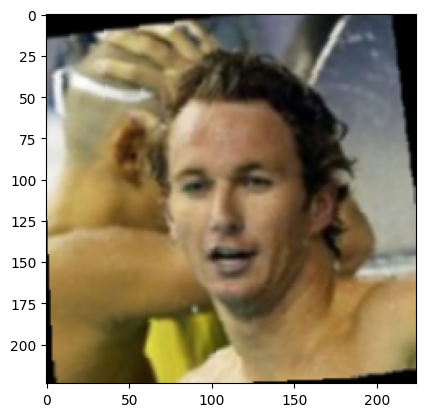

In [39]:
plt.imshow(train_dataset[1][1].permute(1, 2, 0))
plt.show()